In [ ]:
# pip install opencv-python tqdm torch torchvision torchaudio numpy pandas matplotlib pillow scikit-learn  timm

In [1]:
import pandas as pd
import numpy as np
import shutil
import os
import matplotlib.pyplot as plt

import torch


from torch.utils.data import DataLoader, Dataset

In [2]:
import warnings
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=NameError)

In [35]:
# from google.colab import drive
# drive.mount('/content/drive')

In [36]:
!ls "/content/drive/My Drive/data"

'ls' is not recognized as an internal or external command,
operable program or batch file.


# Loading data

In [3]:
# Define your dataset root and class names
raw_data = "../data/dataraw-flowers-data"
train_data_dir = "../data/processed/torch/train"
val_data_dir = "../data/processed/torch/validation"
test_data_dir = "../data/processed/torch/test"

In [ ]:
# Splitting the data into train test and validation
from sklearn.model_selection import train_test_split

all_images = []  # List of an image file and the label
class_dirs = [ "tulip", "sunflower","dandelion", "rose", "daisy"]

for class_dir in class_dirs:
    class_path = os.path.join(raw_data, class_dir)
    for file in os.listdir(class_path):
        if file:
            all_images.append((os.path.join(class_path, file), class_dir))

# Split into training and validation and training sets
train_images, temp = train_test_split(all_images, test_size=0.25, random_state=42, shuffle=True)
test_images, val_images = train_test_split(all_images, test_size=0.4, random_state=42, shuffle=True)

# Training set directory
for image_path, label in train_images:
    destination = os.path.join(train_data_dir, label, os.path.basename(image_path))
    shutil.copy(image_path, destination)

# validation set directory
for image_path, label in val_images:
    destination = os.path.join(val_data_dir, label, os.path.basename(image_path))
    shutil.copy(image_path, destination)

# testing set directory
for image_path, label in test_images:
    destination = os.path.join(test_data_dir, label, os.path.basename(image_path))
    shutil.copy(image_path, destination)

## Data Selection

##### Loading the dataset

In [4]:
import os
import cv2

class FlowersData(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []  # The loaded data i.e., image path and label for each image
        self.labels = os.listdir(root_dir)  # The classes of the floweres are now the labels

        for label in self.labels:
            label_dir = os.path.join(self.root_dir, label)
            for filename in os.listdir(label_dir):
                if filename.endswith((".jpg", ".jpeg", ".png")):
                    self.data.append((os.path.join(label_dir, filename), label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = cv2.imread(img_path)
        image = cv2.resize(image, (224, 224))

        if self.transform:
            image = self.transform(image)

        label_idx = self.labels.index(label)  # Map label to index
        return image, label_idx


In [5]:
# Augmenting data using utility function transforms
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
# create data loader using utility class DataLoader frm torch
train_set_data = FlowersData(train_data_dir, transform=transform)
val_set_data = FlowersData(val_data_dir, transform=transform)
test_set_data = FlowersData(test_data_dir, transform=transform)

train_data_loader = DataLoader(train_set_data, batch_size=32, shuffle=True, num_workers=0)
val_data_loader = DataLoader(val_set_data, batch_size=32, shuffle=True, num_workers=0)
test_data_loader = DataLoader(test_set_data, batch_size=32, shuffle=True, num_workers=0)

In [7]:
flo_classes = train_set_data.labels
num_classes = len(flo_classes)
flo_classes, num_classes

(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'], 5)

In [ ]:
len(train_set_data)

3237

view the dataset


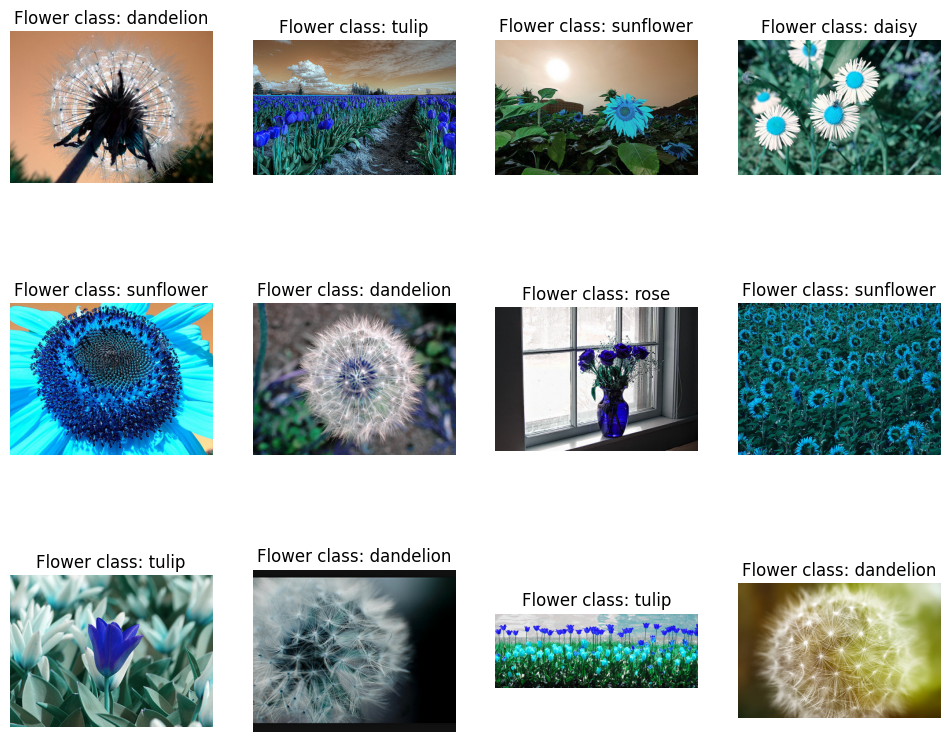

In [ ]:
from random import randint
print("view the dataset")
plt.figure(figsize=(12, 10))

for i in range(12):
    index = randint(0, len(train_data_loader.dataset.data))
    plt.subplot(3, 4, i + 1)
    plt.imshow(cv2.imread(train_data_loader.dataset.data[index][0]))
    plt.title(f"Flower class: {train_data_loader.dataset.data[index][1]}")
    plt.axis("off")

plt.show()

##### Augmenting the datafiles
That is artificially increase size, flipping, varrying contrst and random rotation of training set

In [8]:
IMAGE_SIZE = 224 # As required by Xception model

In [9]:
# Encode the label
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

def encode(labels):
    temp = pd.DataFrame(labels)
    le = LabelEncoder()
    Y = le.fit_transform(temp)
    Y = tf.keras.utils.to_categorical(Y, 5)
    Y_encoded_result = pd.DataFrame(data=Y, columns=le.classes_)
    Y_encoded_result["Label"] = temp
    return Y_encoded_result

AFTER APPLYING TRANSFORMATIONS


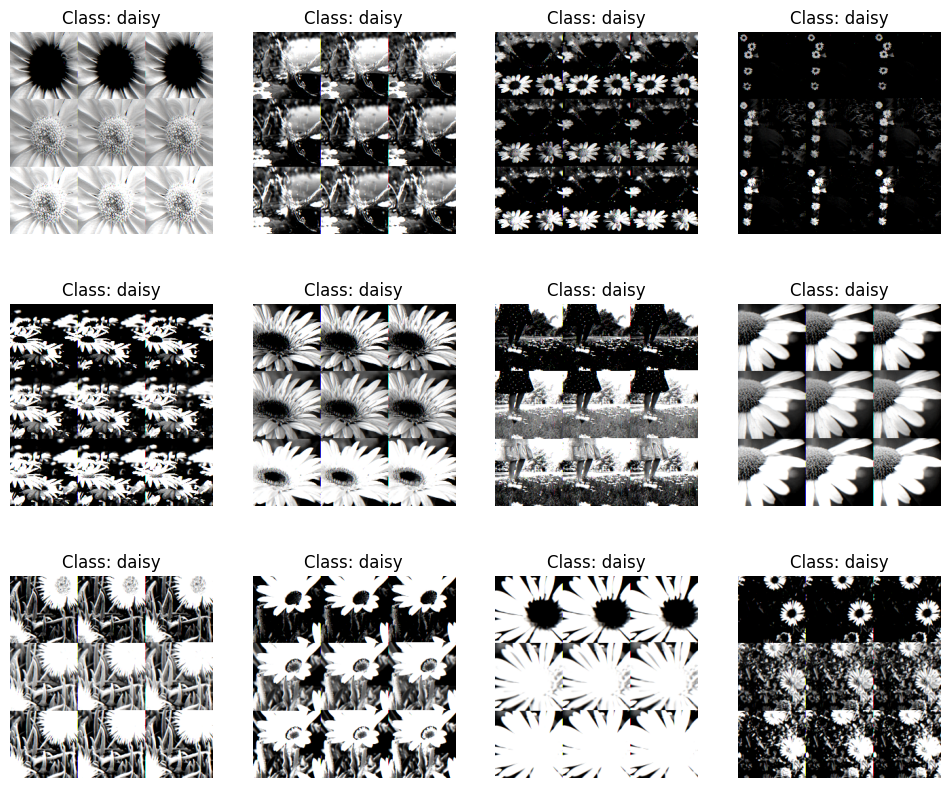

In [ ]:
# Check how the transformation is done
import cv2 as cv2

plt.figure(figsize=(12, 10))
print("AFTER APPLYING TRANSFORMATIONS")
for index in range(12):
    plt.subplot(3, 4, index + 1)
    img = cv2.imread(train_data_loader.dataset.data[index][0])
    img = transform(img)
    plt.imshow(np.clip((img.reshape(224,224,3) + 1) / 2,0,1))
    plt.title(f"Class: {train_data_loader.dataset.data[index][1]}")
    plt.axis("off")

plt.show()

The transformation is quite different from tensor

In [ ]:
# pip install timms

In [14]:
# Looking at shapes
input_image = cv2.imread(train_data_loader.dataset.data[2][0])
input_image = transform(input_image)
input_image.shape

torch.Size([3, 224, 224])

a 3x224x224 image as excepcted by Xception

In [15]:
import timm  # Xception model is not availabel in torchvision.models
import torch.nn as nn

def build_model(num_classes=5):
    model = timm.create_model("xception", pretrained=True)
    # Load pre-trained Xception
    num_features = model.get_classifier().in_features # build in features

    # Remove fully connected layer
    model.fc = nn.Identity()

    # Freeeze all the pretrained layers
    for param in model.parameters():
        param.requires_grad = False

    # Define a new classifier suitable for flower classification
    custom_classifier = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes),
    )
    model.fc = custom_classifier

    return model

In [ ]:
from torchsummary import summary
# Build the model layers and train
model = build_model(5)

In [17]:
summary(model, input_image.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 111, 111]             864
       BatchNorm2d-2         [-1, 32, 111, 111]              64
              ReLU-3         [-1, 32, 111, 111]               0
            Conv2d-4         [-1, 64, 109, 109]          18,432
       BatchNorm2d-5         [-1, 64, 109, 109]             128
              ReLU-6         [-1, 64, 109, 109]               0
            Conv2d-7         [-1, 64, 109, 109]             576
            Conv2d-8        [-1, 128, 109, 109]           8,192
   SeparableConv2d-9        [-1, 128, 109, 109]               0
      BatchNorm2d-10        [-1, 128, 109, 109]             256
             ReLU-11        [-1, 128, 109, 109]               0
           Conv2d-12        [-1, 128, 109, 109]           1,152
           Conv2d-13        [-1, 128, 109, 109]          16,384
  SeparableConv2d-14        [-1, 128, 1

In [18]:

def build_and_train_model( model, optimizer, train_loader):
    criteria = nn.CrossEntropyLoss()

    num_epochs = 3 # train it for 5 epochs
    for epoch in range(num_epochs):
        model.train()  # Model for training
        running_loss = 0.0

        for images, labels in train_loader:
            optimizer.zero_grad()  # Reset gradients
            outputs = model(images) # perform a Forward pass
            loss = criteria(outputs, labels)  # Calculate losses
            loss.backward()  # a Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item() * images.size(0)  # Accumulative loss

        epoch_loss = running_loss / len(train_data_loader.dataset)  # Average loss for the epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    try:
        
        torch.save(model.state_dict(), '../trained-models/pytorch.pth')
        state_dict = torch.load("../trained-models/pytorch.pth")
    except:
        pass
    return state_dict

In [19]:
# Set up an optimizer Adma
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# For classification task
criterion = nn.CrossEntropyLoss()
# use a learning scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [20]:
# training the model and return the state_dict of trained model
state_dict = build_and_train_model(model, optimizer, train_data_loader)

Epoch [1/3], Loss: 0.8669
Epoch [2/3], Loss: 0.5961
Epoch [3/3], Loss: 0.5553


##### Evaluating and validation the models

Unlike tensor validation is done seperately

In [21]:
def evaluate_model(model, val_data_loader, loss_criteria):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Dont compute gradient
        for images, labels in val_data_loader:
            outputs = model(images)  # Forward pass

            loss = loss_criteria(outputs, labels)  # Calculate loss
            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss /= len(val_data_loader.dataset)  # Average loss for validation
        accuracy = correct / total * 100  # Calculate accuracy

    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")

In [22]:
# calculate metrics using sklearn
from sklearn import metrics
def calculate_metrics(true_classes, pred_classes):
    # Accuracy score
    accuracy = metrics.accuracy_score(true_classes, pred_classes)
    # precision score
    precision = metrics.precision_score(true_classes, pred_classes, average='macro')
    # recall
    recall = metrics.recall_score(true_classes, pred_classes, average='macro')
    # f1 score
    f1 = metrics.f1_score(true_classes, pred_classes, average='macro')

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("F1-score:", f1)
    print("Recall:", recall)

In [23]:
def get_predictions(model, data_loader):
    model.eval()  # set up model for prediction

    true_classes = [] # Actual class
    pred_classes = [] # predicted class

    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            true_classes.extend(labels.cpu().numpy())  
            pred_classes.extend(predicted.cpu().numpy())
        
    return true_classes, pred_classes

In [24]:
# Confusion metrics
import seaborn as sns
import matplotlib.pyplot as plt

def get_conf_matrix(true_classes, pred_classes, dataset):
    confusion_matrix = metrics.confusion_matrix(true_classes, pred_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.labels, yticklabels=dataset.labels)
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
# Load the saced model
state_dict = torch.load('../trained-models/pytorch.pth')

# Inixialize xception  model
model = build_model()
model.load_state_dict(state_dict)
criterion = nn.CrossEntropyLoss()

#### Evaluate

In [26]:
# Get the predictions
true_classes, pred_classes = get_predictions(model, val_data_loader)

In [27]:
# Calculate metrics
calculate_metrics(true_classes, pred_classes)

Accuracy: 0.842501447596989
Precision: 0.8455210595933418
F1-score: 0.8392363685013713
Recall: 0.8392916819355177


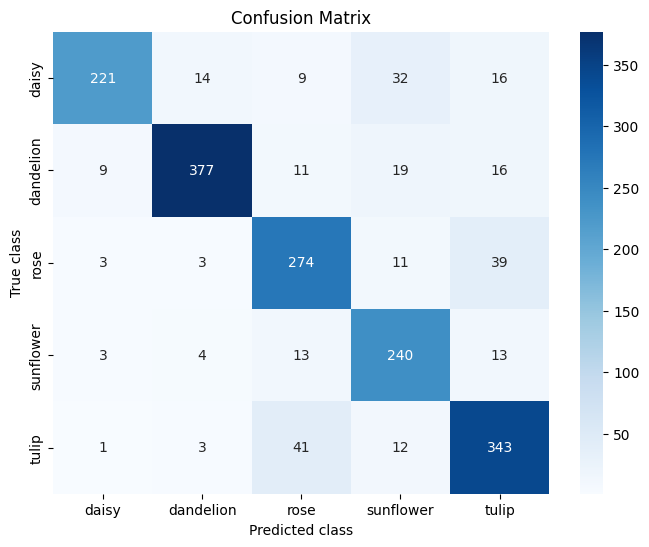

In [28]:
# get the confusion matrix
get_conf_matrix(true_classes, pred_classes, val_data_loader.dataset)